**<span style="font-size:27px;">Forecasting Monthly Milk Production data with seasonal ARIMA</span>**

**<span style="font-size:24px;">Goal</span>**

*<span style="font-size:16px;">The primary objective of this project is to accurately forecast future monthly milk production using Seasonal ARIMA (SARIMA) model. By leveraging historical milk production data, the project aims to develop a robust predictive model that can:</span>*

*<span style="font-size:16px;">Enhance Understanding: Provide insights into the historical trends, seasonal patterns, and cyclical fluctuations in milk production.</span>*
    
*<span style="font-size:16px;">Predict Future Values: Generate reliable monthly forecasts for milk production to aid in inventory management, supply chain optimization, and strategic planning for dairy producers.</span>*
    
*<span style="font-size:16px;">Assess Model Performance: Evaluate the accuracy and effectiveness of the SARIMA model in predicting monthly milk production and compare its performance with other forecasting methods if necessary.</span>*

**<span style="font-size:24px;">Setup</span>**

**<span style="font-size:18px;">Importing the necessary libraries I will use for this project</span>**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.api import (kpss, adfuller, 
                                 seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm
from pathlib import Path


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]  

**<span style="font-size:18px;">Reading in the data</span>**

In [3]:
milk = pd.read_csv('C:\Liza\Учёба\Data analytics\My portfolio\milk_production.csv', index_col='month', parse_dates=True,skipfooter=1)

**<span style="font-size:18px;">Looking at the data</span>**

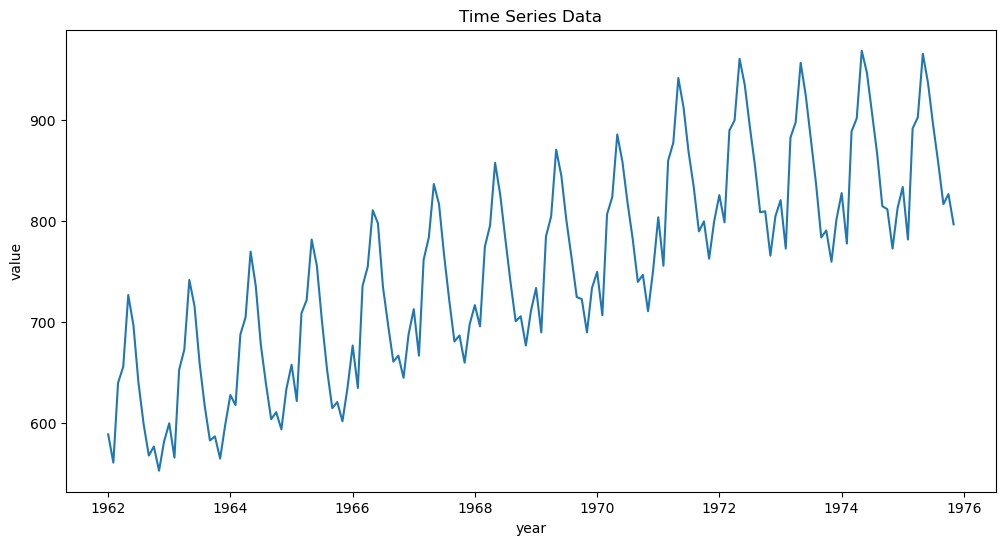

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(milk)
plt.xlabel('year')
plt.ylabel('value')
plt.title('Time Series Data')
plt.show()

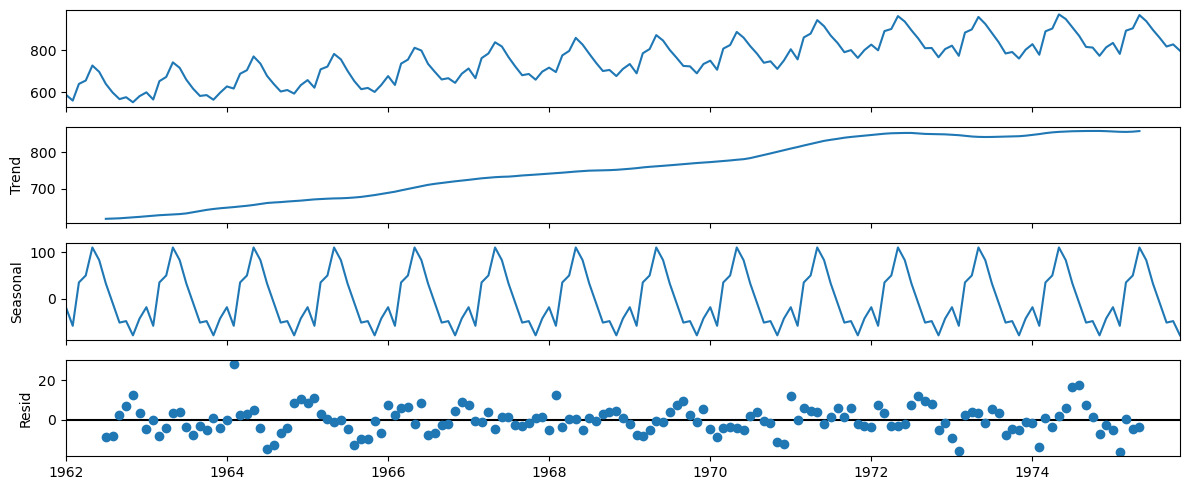

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(milk, model='additive', period=12)
decomposition.plot()
plt.show()

**<span style="font-size:18px;">Creating a function to check stationary of time series</span>**

In [7]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [8]:
 def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='-')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

**<span style="font-size:18px;">Creating a generalized function, split_data, which splits the data based on a test split factor</span>**

In [9]:
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [10]:
test_split = 0.15
milk_train, milk_test = split_data(milk, test_split)

train: 142 , test: 25


In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.rcParams["figure.figsize"] = [14, 4]  

**<span style="font-size:18px;">Exploring the autocorrelation and partial autocorrelation of the time series</span>**

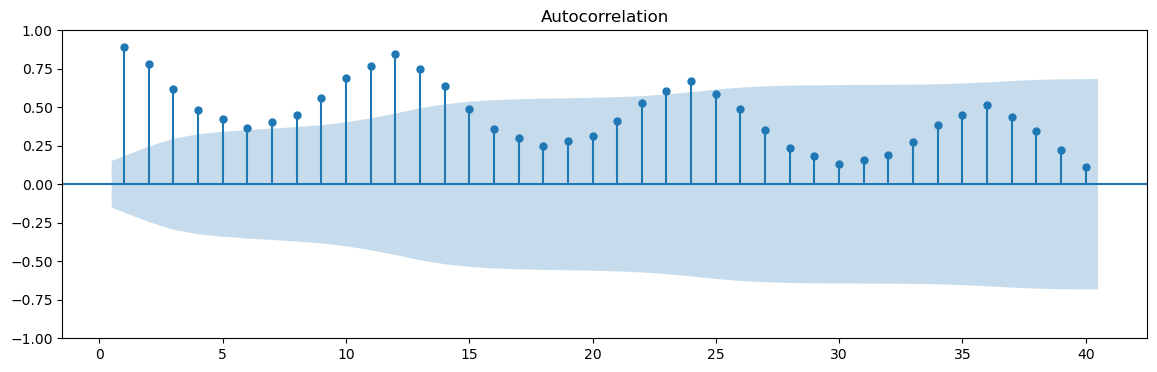

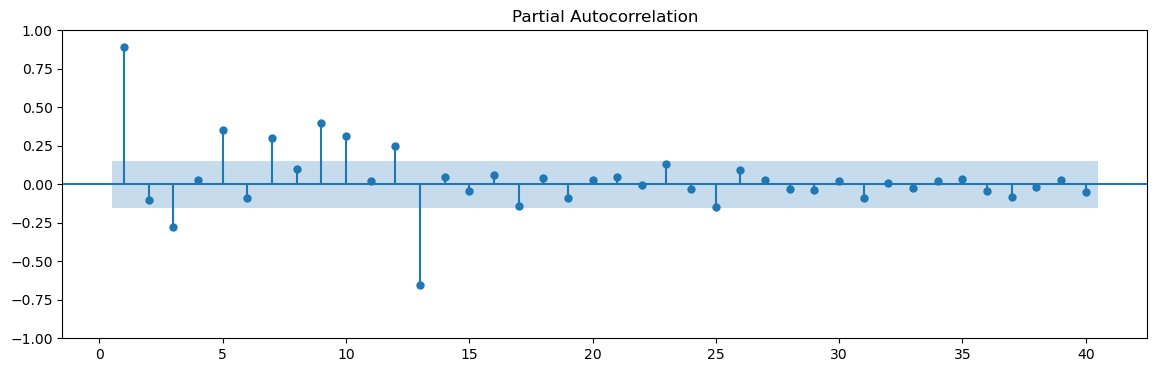

In [12]:
plot_acf(milk, lags=40, zero=False)
plot_pacf(milk, lags=40, zero=False);plt.show()

**<span style="font-size:18px;">Exploring the autocorrelation of the first differences</span>**

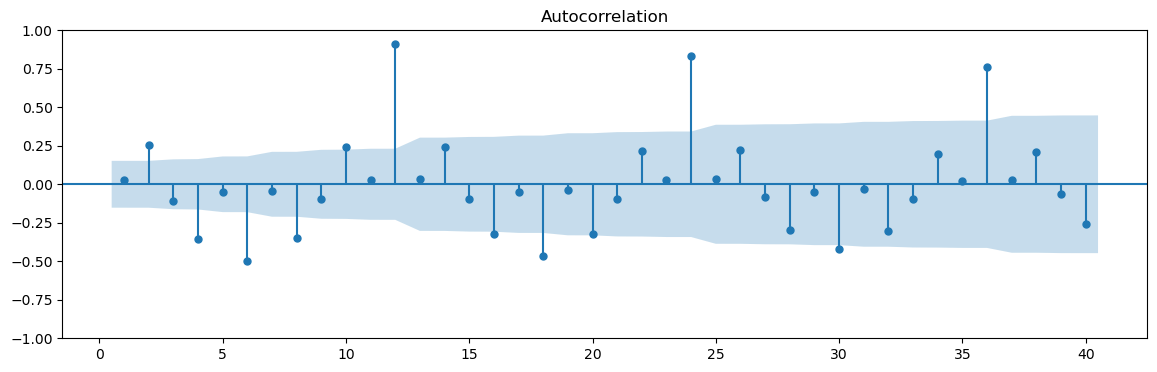

In [13]:
plot_acf(milk.diff(1).dropna(), lags=40, zero=False); plt.show()

**<span style="font-size:18px;">Extracting the seasonal component</span>**

In [17]:
decomposed = seasonal_decompose(milk, period=12, model='multiplicative')
milk_s = decomposed.seasonal

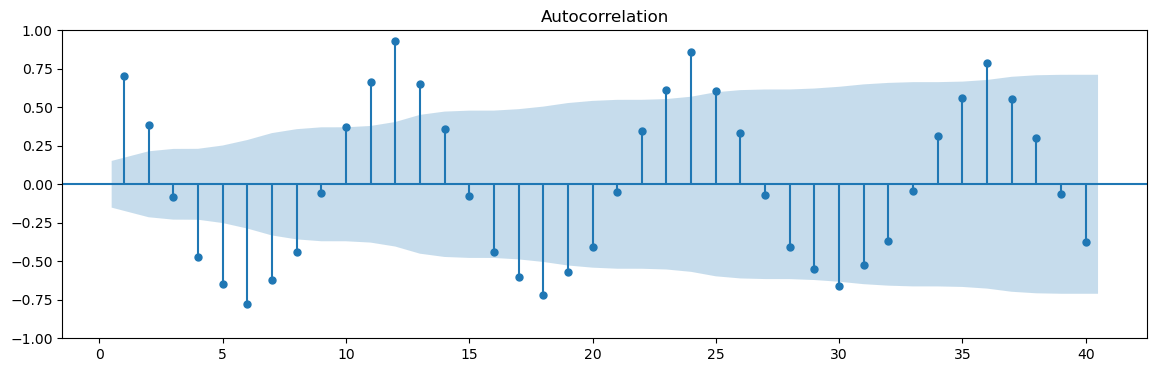

In [18]:
plot_acf(milk_s, zero=False, lags=40);plt.show()

In [19]:
milk_dif_12 = milk.diff(12).dropna()
milk_dif_12_1 = milk.diff(12).diff(1).dropna()

**<span style="font-size:18px;">Checking stationary of the time series</span>**

*<span style="font-size:16px;">Starting with seasonal differencing by using diff(12) (deseasonalize) and testing if that 
is enough to make the time series stationarity. If not, then we will need to follow it with a first-order differencing, diff():</span>*

'Non-Stationary	 p-value:0.5738663607179357 	 lags:13
'Non-Stationary	 p-value:0.16273488859119156 	 lags:12
'Stationary	 p-value:1.9152070812001068e-05 	 lags:11


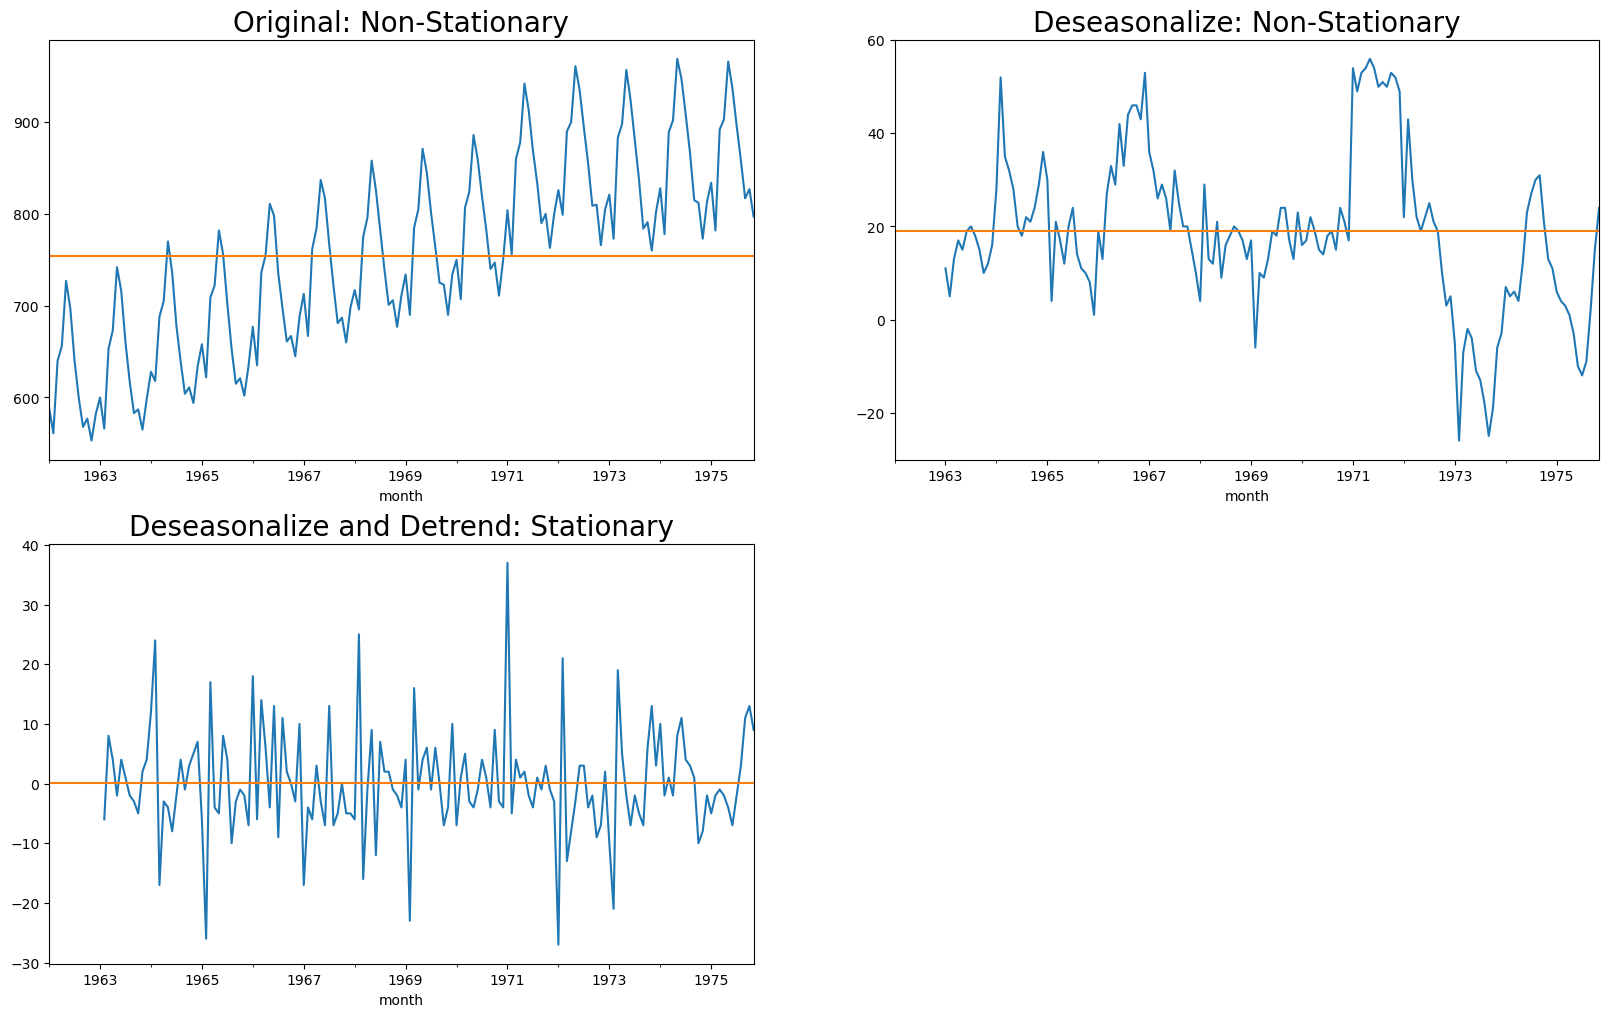

In [20]:
sets = [milk, milk_dif_12, milk_dif_12_1]
desc = ['Original', 'Deseasonalize', 'Deseasonalize and Detrend']
fig, ax = plt.subplots(2,2, figsize=(20,12))
index, l = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    v, r = i // 2, i % 2
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax= ax[v,r], title=f'{d_desc}: {outcome}', legend=False)
    pd.Series(d_set.mean().values.tolist()*l, index=index).plot(ax=ax[v,r])
    ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
plt.show()

**<span style="font-size:18px;">Estimating the AR and MA orders for the non-seasonal (p, q) and seasonal components (P, Q)</span>**

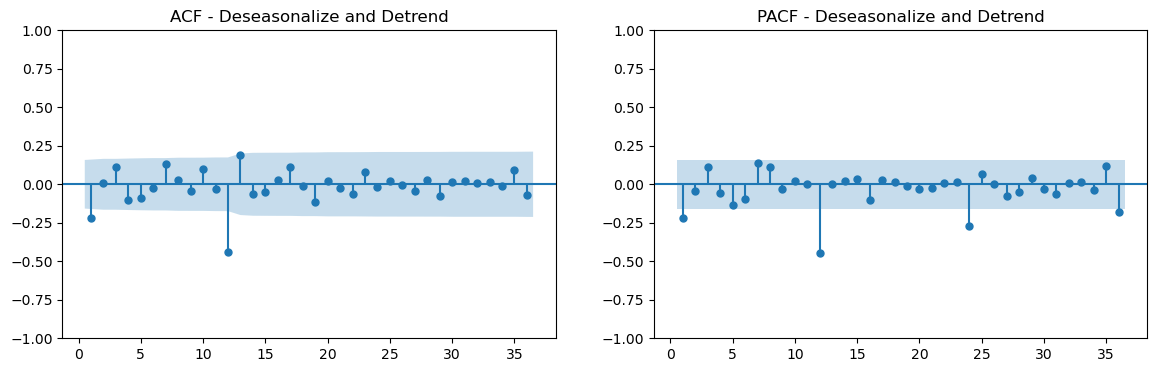

In [21]:
fig, ax = plt.subplots(1,2)
plot_acf(milk_dif_12_1, zero=False, lags=36, ax=ax[0], title=f'ACF - {d_desc}')
plot_pacf(milk_dif_12_1, zero=False, lags=36, ax=ax[1], title=f'PACF - {d_desc}')
plt.show()

*<span style="font-size:16px;">Starting with the ACF plot, there is a significant spike at lag 1, which represents the 
non-seasonal order for the MA process. The spike at lag 12 represents the seasonal order for the MA process. Notice that there is a cut-off right after lag 1, then a spike at lag 12, followed by another cut-off (no other significant lags afterward). These are indications of a moving average model – more specifically, an order of q=1 and Q=1.</span>*
    
*<span style="font-size:16px;">The PACF plot confirms this as well; an exponential decay at lags 12, 24, and 36 
indicates an MA model. Here, the seasonal ARIMA would be ARIMA(0, 1,1) 
(0, 1, 1, 12)</span>*

[1, 12, 24, 36, 48]


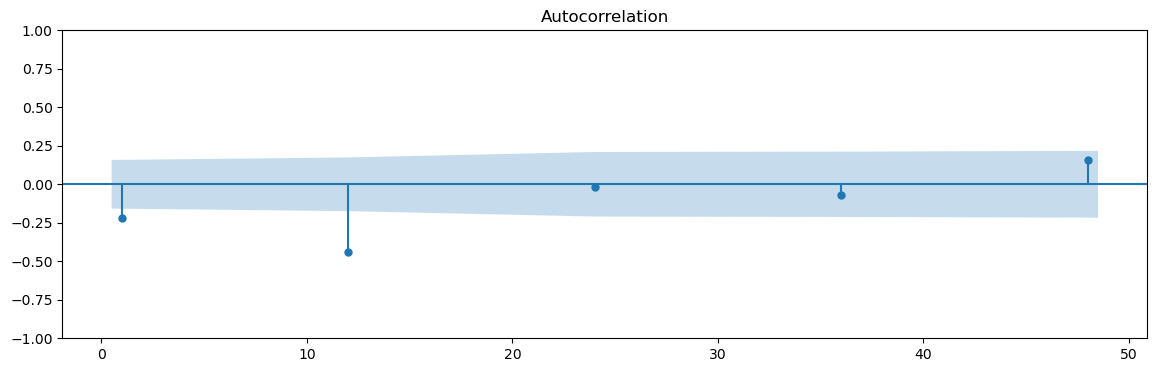

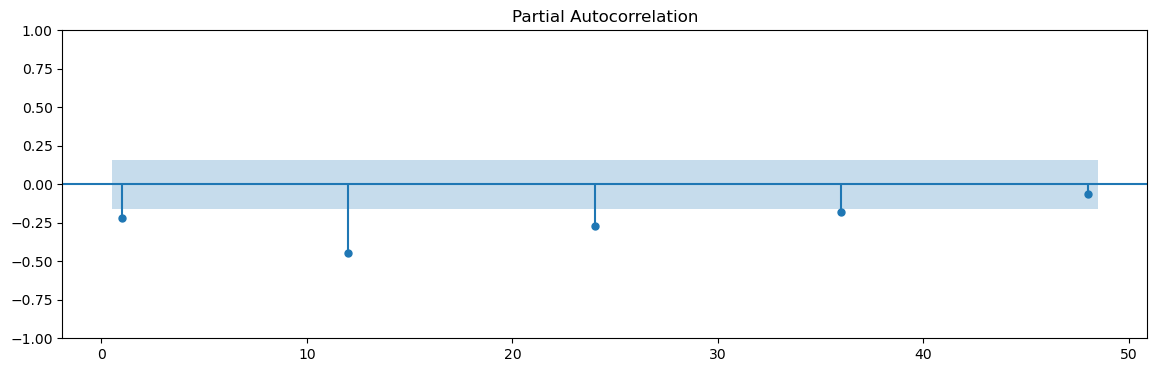

In [22]:
#lags = [1, 12, 24, 36, 48]
lags = [i for i in range(12, 60, 12)]
lags.insert(0, 1)
print(lags)
plot_acf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags)
plot_pacf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags);

**<span style="font-size:18px;">Fitting a SARIMA model</span>**

In [23]:
sarima_model = SARIMAX(milk_train, 
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

**<span style="font-size:18px;">Inspecting the distribution of the residuals</span>**

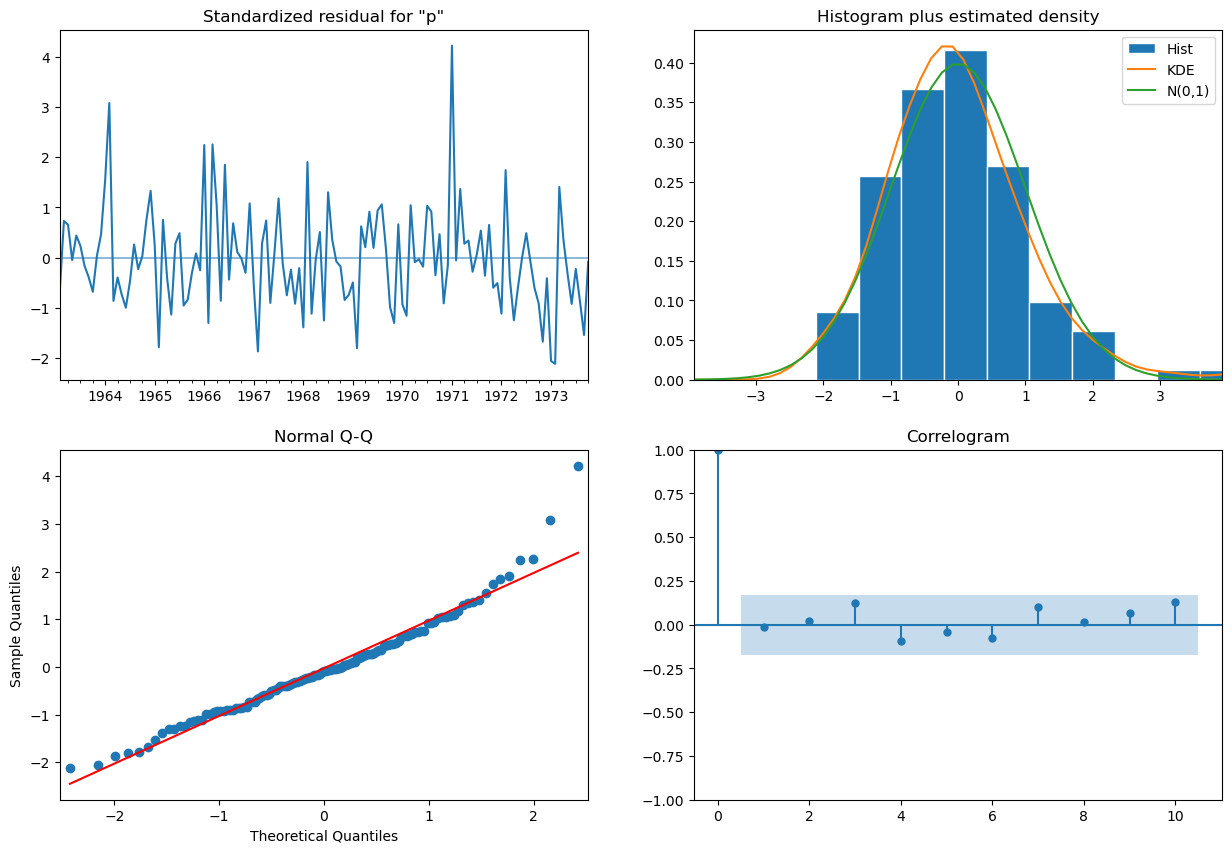

In [24]:
model.plot_diagnostics(figsize=(15,10))
plt.show()

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         production   No. Observations:                  142
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -445.404
Date:                            Tue, 28 May 2024   AIC                            896.808
Time:                                    14:18:14   BIC                            905.387
Sample:                                01-01-1962   HQIC                           900.294
                                     - 10-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2779      0.084     -3.293      0.001      -0.443      -0.112
ma.S.L12      -0.6199      0.086     -7.200      0.000      -0.789      -0.451
sigma2        55.8092      5.854      9.533      0.000      44.335      67.283
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                38.42
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.85
Prob(H) (two-sided):                  0.70   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='month'>

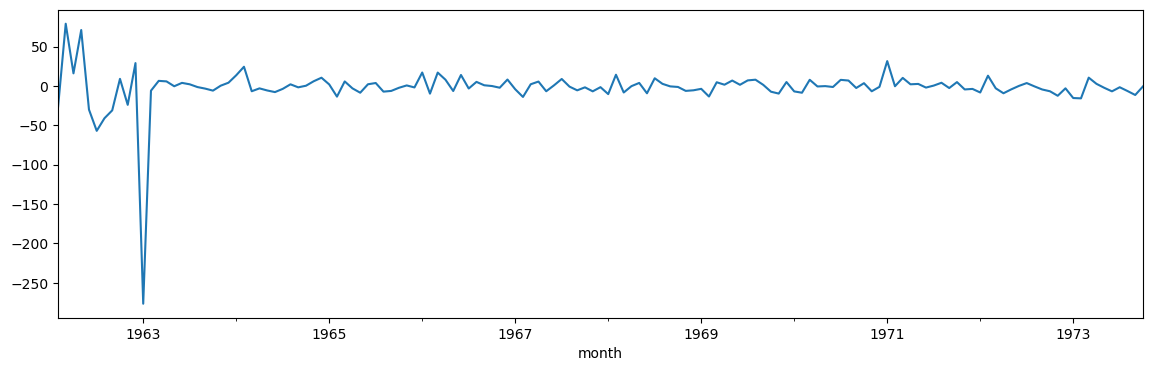

In [26]:
model.resid[1:].plot()

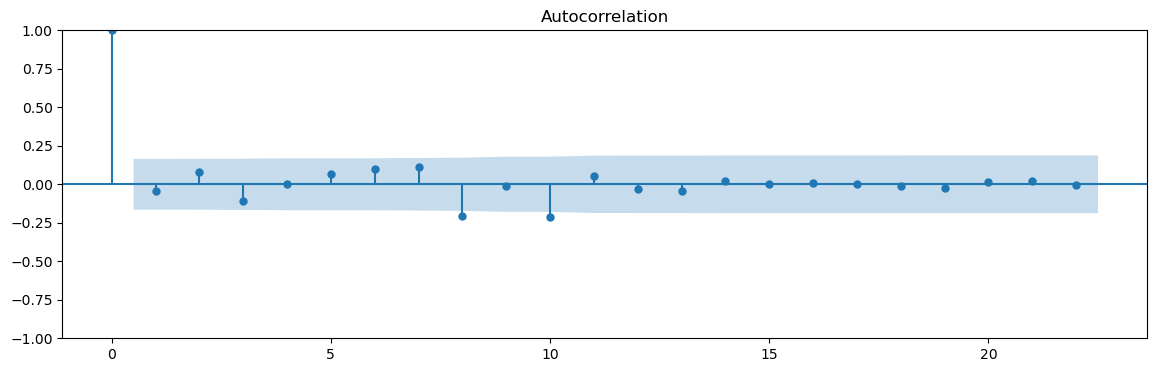

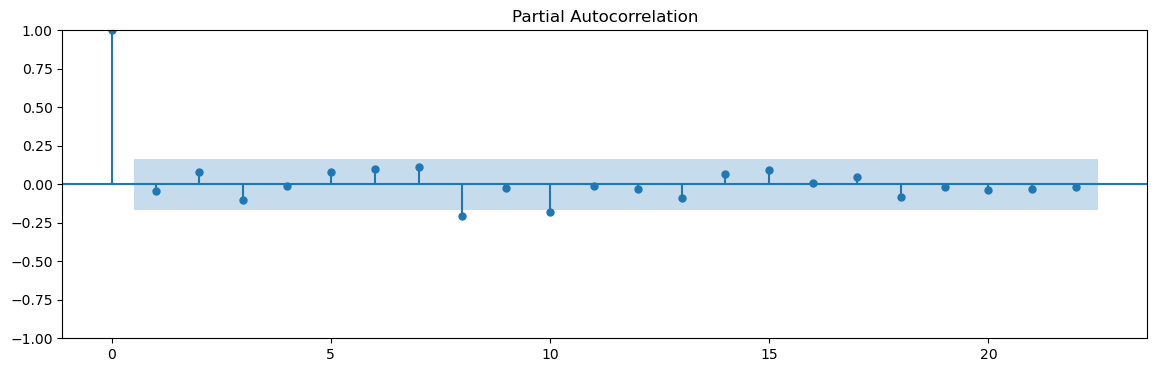

In [27]:
plot_acf(model.resid[1:])
plot_pacf(model.resid[1:]); plt.show()

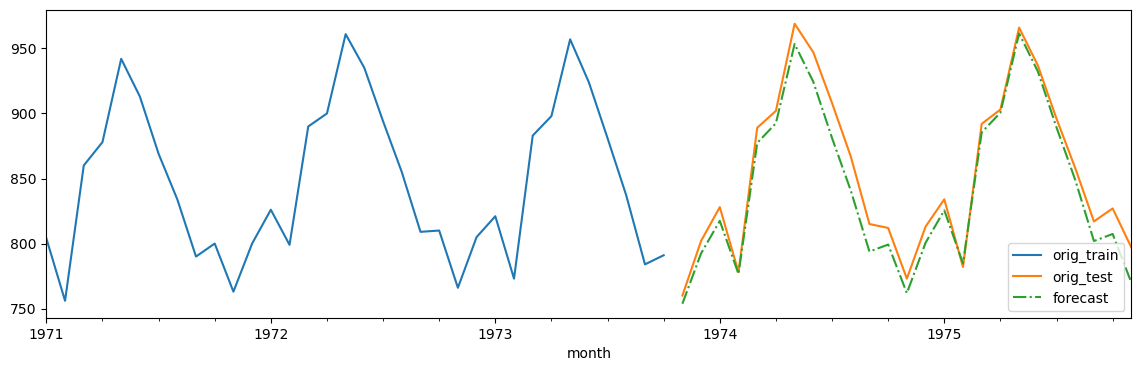

In [28]:
plot_forecast(model, '1971', milk_train, milk_test)

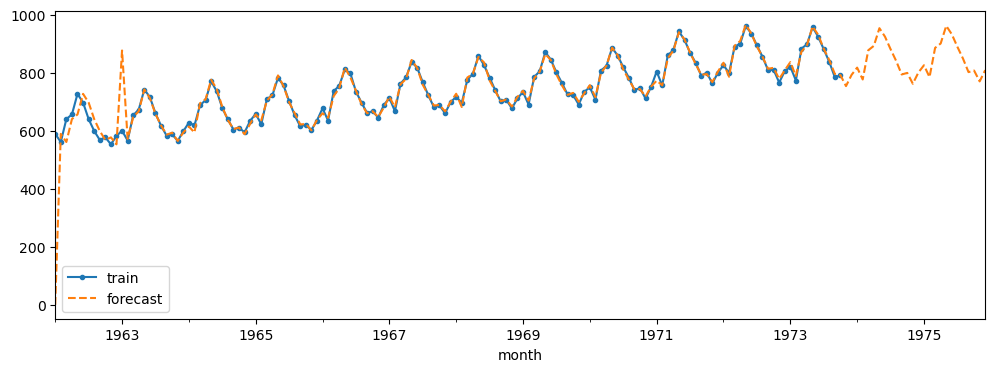

In [29]:
n = milk.shape[0]
milk_train.plot(style='.-', figsize=(12,4))
model.predict(end=n).plot(style='--')
plt.legend(['train', 'forecast'])

**<span style="font-size:20px;">Conclusion</span>**

*<span style="font-size:16px;">The project focused on forecasting monthly milk production using the Seasonal ARIMA (SARIMA) model has successfully achieved its objectives, providing valuable insights and reliable forecasts. Through a systematic approach encompassing data collection, preprocessing, model development, and evaluation, we have gained a comprehensive understanding of milk production trends and seasonal patterns.</span>*

*<span style="font-size:16px;">Through extensive exploratory data analysis, we identified significant trends, seasonal patterns, and cyclical fluctuations in milk production. Visualizations of historical data revealed clear seasonal peaks and troughs, which informed our modeling approach. Understanding these patterns was essential for developing a robust SARIMA model.</span>*

*<span style="font-size:16px;">We developed the Seasonal ARIMA (SARIMA) model, carefully identifying and tuning the appropriate order of autoregressive (AR), differencing (I), moving average (MA), and seasonal components (SAR, SI, SMA). The SARIMA model effectively captured both the trend and seasonal variations in the milk production data, demonstrating its suitability for this type of time series.</span>*

*<span style="font-size:16px;">The performance of the SARIMA model was rigorously evaluated using metrics such as Mean Absolute Error (MAE) and Mean Squared Error (MSE). These evaluations confirmed the model's reliability and accuracy in forecasting monthly milk production. Additionally, we compared the SARIMA forecasts with those generated by other forecasting techniques, validating SARIMA's superior performance in this context.</span>*

*<span style="font-size:16px;">Using the SARIMA model, we generated forecasts for monthly milk production for the next 24 months. The forecasts provide valuable insights, indicating expected production levels and seasonal variations. These insights are critical for dairy producers and supply chain managers, aiding in inventory management, supply chain optimization, and strategic planning.</span>*